The goal is make a model that could predict for the features the Severity of the Accident
and analyze the most important features that could lead to an accident.

Let's start importing everuthing that we need

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sbn
import lazypredict
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_auc_score #scores metrics measures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #matrix confusion
from xgboost import plot_importance
from lazypredict.supervised import LazyClassifier
import joblib
import shap
import torch
import torch.nn as nn
import torch.utils.data as td
from scipy.stats import shapiro

In [3]:
#Loading the data 2.59 GB
data= pd.read_csv('./US_Accidents_March23.csv')

In [4]:
#EDA
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

The dataset have bool(13), float64(12), int64(1), object(20) and some missing values


In [5]:
data.shape

(7728394, 46)

In [6]:
data.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7728394.00,7728394.00,7728394.00,4325632.00,4325632.00,7728394.00,7564541.00,5729375.00,7554250.00,7587715.00,7551296.00,7157161.00,5524808.00
mean,2.21,36.20,-94.70,36.26,-95.73,0.56,61.66,58.25,64.83,29.54,9.09,7.69,0.01
std,0.49,5.08,17.39,5.27,18.11,1.78,19.01,22.39,22.82,1.01,2.69,5.42,0.11
min,1.00,24.55,-124.62,24.57,-124.55,0.00,-89.00,-89.00,1.00,0.00,0.00,0.00,0.00
25%,2.00,33.40,-117.22,33.46,-117.75,0.00,49.00,43.00,48.00,29.37,10.00,4.60,0.00
50%,2.00,35.82,-87.77,36.18,-88.03,0.03,64.00,62.00,67.00,29.86,10.00,7.00,0.00
75%,2.00,40.08,-80.35,40.18,-80.25,0.46,76.00,75.00,84.00,30.03,10.00,10.40,0.00
max,4.00,49.00,-67.11,49.08,-67.11,441.75,207.00,207.00,100.00,58.63,140.00,1087.00,36.47


There are 7 million+  rows and 46 columns and there are 2 columns that are not so important for us ID and Source but first let's make a copy of our data to work with the copy .

In [7]:
df= data.copy()

#Let's drop the columns that are not so important for us

In [8]:
df= df.drop(['ID', 'Source'], axis=1)

Now let's check if there are missing values

In [9]:
df.isna().sum()

Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump                           0
Crossing                       0
Give_Way  

There are a lot of missing values in the dfset, we need to handle them

In [10]:
df= df.dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3554549 entries, 3402762 to 7728393
Data columns (total 44 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   End_Time               object 
 3   Start_Lat              float64
 4   Start_Lng              float64
 5   End_Lat                float64
 6   End_Lng                float64
 7   Distance(mi)           float64
 8   Description            object 
 9   Street                 object 
 10  City                   object 
 11  County                 object 
 12  State                  object 
 13  Zipcode                object 
 14  Country                object 
 15  Timezone               object 
 16  Airport_Code           object 
 17  Weather_Timestamp      object 
 18  Temperature(F)         float64
 19  Wind_Chill(F)          float64
 20  Humidity(%)            float64
 21  Pressure(in)           float64
 22  Visibility(mi)   

After drop all the Null values the dfset now have 3,554,549 rows and 44 columns the only rare here was that there was accident with 0 miles of Distance but I'll touch that later,now like I have the Street, city,county and State I think that for this analysis the lat and long and description stats are not to importants so we will drop them, and like all the accidents are in USA I'll drop Country too 

In [12]:
df= df.drop(['Start_Lat', 'Start_Lng','End_Lat', 'End_Lng','Description','Country'], axis=1)

Now it's time to make the Start_time and End_time to datetime

In [13]:
#df['Start_Time'] = pd.to_datetime(df['Start_Time'])
#df['End_Time'] = pd.to_datetime(df['End_Time'])

At the time to make Start_Time to datetime i get an error that i have a format "%Y-%m-%d %H:%M:%S": ".000000000", at position 9262. So let's go to fixe it.

In [14]:

#The problem is that the row have a value of 0.000000000 at the end they're more than one so it's time to fix it.

df['Start_Time']= df['Start_Time'].astype(str).str.split('.').str[0]
df['End_Time']= df['End_Time'].astype(str).str.split('.').str[0]

#Now let's check if the problem was solved

print(df[df['Start_Time'].str.contains('.000000000')]['Start_Time'].head(5))
print(df[df['End_Time'].str.contains('.000000000')]['End_Time'].head(5))


Series([], Name: Start_Time, dtype: object)
Series([], Name: End_Time, dtype: object)


We already fix it so now we can proced to convert to datetime

In [15]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

In [16]:
#Let's check if it worked

df.info()#It worked

<class 'pandas.core.frame.DataFrame'>
Index: 3554549 entries, 3402762 to 7728393
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Severity               int64         
 1   Start_Time             datetime64[ns]
 2   End_Time               datetime64[ns]
 3   Distance(mi)           float64       
 4   Street                 object        
 5   City                   object        
 6   County                 object        
 7   State                  object        
 8   Zipcode                object        
 9   Timezone               object        
 10  Airport_Code           object        
 11  Weather_Timestamp      object        
 12  Temperature(F)         float64       
 13  Wind_Chill(F)          float64       
 14  Humidity(%)            float64       
 15  Pressure(in)           float64       
 16  Visibility(mi)         float64       
 17  Wind_Direction         object        
 18  Wind_Speed(mph)      

Now I noticed that the name of the columns are a littel bit complicate so let's change the name of the columns to something more simple and clear

In [17]:
df= df.rename(columns={'Distance(mi)':'Distance','Temperature(F)':'Temperature',
                           'Wind_Chill(F)':'Wind_Chill','Humidity(%)':'Humidity',
                           'Pressure(in)':'Pressure','Visibility(mi)':'Visibility',
                           'Wind_Speed(mph)':'Wind_Speed','Precipitation(in)':'Precipitation'})

Now I got 'County', 'State', 'Zipcode','Street','City','Timezone','Airport_Code' as a object so I'll convert to string

In [18]:
for i in ['County', 'State', 'Zipcode','Street','City','Timezone','Airport_Code']:
   df[i]= df[i].astype('string')

Let's check if it worked


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3554549 entries, 3402762 to 7728393
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Severity               int64         
 1   Start_Time             datetime64[ns]
 2   End_Time               datetime64[ns]
 3   Distance               float64       
 4   Street                 string        
 5   City                   string        
 6   County                 string        
 7   State                  string        
 8   Zipcode                string        
 9   Timezone               string        
 10  Airport_Code           string        
 11  Weather_Timestamp      object        
 12  Temperature            float64       
 13  Wind_Chill             float64       
 14  Humidity               float64       
 15  Pressure               float64       
 16  Visibility             float64       
 17  Wind_Direction         object        
 18  Wind_Speed           

It worked and now let's check the datetimes columns but we gonna add the Weather_Condition feature 

In [20]:
df[['Start_Time','End_Time','Weather_Condition','Weather_Timestamp']]

,Start_Time,End_Time,Weather_Condition,Weather_Timestamp
3402762,2016-02-08 00:37:08,2016-02-08 06:37:08,Light Rain,2016-02-08 00:53:00
3402767,2016-02-08 07:53:43,2016-02-08 13:53:43,Light Rain,2016-02-08 07:53:00
3402771,2016-02-08 11:51:46,2016-02-08 17:51:46,Snow,2016-02-08 11:51:00
3402773,2016-02-08 15:16:43,2016-02-08 21:16:43,Snow,2016-02-08 15:12:00
3402774,2016-02-08 15:43:50,2016-02-08 21:43:50,Light Snow,2016-02-08 15:47:00
...,...,...,...,...
7728389,2019-08-23 18:03:25,2019-08-23 18:32:01,Fair,2019-08-23 17:53:00
7728390,2019-08-23 19:11:30,2019-08-23 19:38:23,Fair,2019-08-23 18:53:00
7728391,2019-08-23 19:00:21,2019-08-23 19:28:49,Partly Cloudy,2019-08-23 18:53:00
7728392,2019-08-23 19:00:21,2019-08-23 19:29:42,Fair,2019-08-23 18:51:00


All have the same format but sometimes the Weather_Timestamp don't have the same time of when the accident started.
But I don't think that the Weather_Timestamp will be relevant so I'm gonna drop it.

In [21]:
df= df.drop('Weather_Timestamp',axis=1)

Now It's time to encode the boolean and string features

In [22]:
def encodeBooleans(d,value):
    df[d]= np.where(df[d] == value,1,0)
    
for i in df.columns:
    if ((df[i].dtype) == bool):
        encodeBooleans(i,True)

Now let's check the object types of the dataset

In [23]:
for i in df.columns:
   if df[i].dtype == object:
       print(i+'\n')
       print(df[i].unique())
       print('-------------------------------')

Wind_Direction

['SW' 'WSW' 'West' 'NNW' 'WNW' 'NW' 'W' 'SSW' 'East' 'SE' 'North' 'ENE'
 'NNE' 'NE' 'SSE' 'CALM' 'South' 'ESE' 'S' 'Variable' 'VAR' 'N' 'E']
-------------------------------
Weather_Condition

['Light Rain' 'Snow' 'Light Snow' 'Mostly Cloudy' 'Cloudy' 'Partly Cloudy'
 'Overcast' 'Scattered Clouds' 'Light Freezing Drizzle' 'Light Drizzle'
 'Rain' 'Fair' 'Fog' 'Haze' 'Light Freezing Rain' 'Clear' 'Heavy Snow'
 'Drizzle' 'Heavy Rain' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Blowing Snow' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Rain'
 'Thunderstorms and Rain' 'Light Thunderstorms and Snow' 'Mist' 'T-Storm'
 'Rain / Windy' 'Wintry Mix' 'Heavy Thunderstorms and Rain'
 'Partly Cloudy / Windy' 'Heavy T-Storm' 'Shallow Fog'
 'Light Rain / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Freezing Rain / Windy' 'Light Freezing Fog' 'Mostly Cloudy / Windy'
 'S

We can see that Sunrise_Sunset Civil_Twilight ,Nautical_Twilight and Astronomical_Twilight have the same values 'Night' and 'Day' so let's encode dem with day =1 and night = 0

In [24]:
for i in df.columns:
   if df[i].dtype == object and len(df[i].unique()) == 2:
       encodeBooleans(i,'Day')

Now let's convert to string Weather_condition and Wind_direction 


In [25]:
df['Wind_Direction']= df['Wind_Direction'].astype('string')
df['Weather_Condition']= df['Weather_Condition'].astype('string')  

Now let's get the dumies for Weather_condition

In [26]:
dumies= pd.get_dummies(df['Weather_Condition'])

Now let's add the dumies to the df

In [27]:
df = pd.concat([df,dumies],axis=1)

And now we can drop the Weather_Condition feature

In [28]:
df = df.drop('Weather_Condition',axis=1)

Now let's make the same procedure with the new boolean values

In [29]:
for i in df.columns:
    if ((df[i].dtype) == bool):
        encodeBooleans(i,True)

In [30]:
df.info()#To check if it work, it did


<class 'pandas.core.frame.DataFrame'>
Index: 3554549 entries, 3402762 to 7728393
Columns: 158 entries, Severity to Wintry Mix / Windy
dtypes: datetime64[ns](2), float64(8), int32(139), int64(1), string(8)
memory usage: 2.4 GB


Now I'm gonna check for Wind_direction feature 

In [31]:
df['Wind_Direction'].unique()

<StringArray>
[      'SW',      'WSW',     'West',      'NNW',      'WNW',       'NW',
        'W',      'SSW',     'East',       'SE',    'North',      'ENE',
      'NNE',       'NE',      'SSE',     'CALM',    'South',      'ESE',
        'S', 'Variable',      'VAR',        'N',        'E']
Length: 23, dtype: string

There are the same direction with different names so lets format in only one mode like N or SW
I'm gonna create a mapping dictionary to efficiently replace the values in the 'Wind_Direction' column because I can do that with string if not I could use the map() method.

In [32]:
wind_direction_mapping = {
    'Variable': 'VAR',
    'South':'S',
    'North':'N',
    'East':'E',
    'West':'W',
    'North-Northeast': 'NNE',
    'North Northeast': 'NNE',
    'Northeast': 'NE',
    'East-Northeast': 'ENE',
    'East Northeast': 'ENE',
    'East-Southeast': 'ESE',
    'East Southeast': 'ESE',
    'Southeast': 'SE',
    'South-Southeast': 'SSE',
    'South Southeast': 'SSE',
    'South-Southwest': 'SSW',
    'South Southwest': 'SSW',
    'West-Southwest': 'WSW',
    'West Southwest': 'WSW',
    'West-Northwest': 'WNW',
    'West Northwest': 'WNW',
    'North-Northwest': 'NNW',
    'North Northwest': 'NNW',
    'CALM': 'CALM',
}        
df['Wind_Direction'] = df['Wind_Direction'].replace(wind_direction_mapping)

Now let's check the result

In [33]:
df['Wind_Direction'].unique()

<StringArray>
[  'SW',  'WSW',    'W',  'NNW',  'WNW',   'NW',  'SSW',    'E',   'SE',
    'N',  'ENE',  'NNE',   'NE',  'SSE', 'CALM',    'S',  'ESE',  'VAR']
Length: 18, dtype: string

Now let's get dumies,encode and concat Wind direction

In [34]:
dumies_direction= pd.get_dummies(df['Wind_Direction'])

for i in dumies_direction.columns:
    if ((dumies_direction[i].dtype) == bool):
        dumies_direction[i]= np.where(dumies_direction[i] == True,1,0)

df= pd.concat([df,dumies_direction],axis=1)

#And now we can drop Wind_direction
df= df.drop('Wind_Direction',axis=1)


Then let's check the Zipcode feature

In [35]:
df['Zipcode'].unique()
#There are a lot unique zipcodes, but there are two format xxxxx or xxxxx-xxxx so I'll let 
#the format xxxxx 
df['Zipcode']= df['Zipcode'].str.split('-').str[0]


Let's check if it worked

In [36]:
df['Zipcode'][df['Zipcode'].str.contains('-')].str.split('-').head(10)

Series([], Name: Zipcode, dtype: object)

Now it's time to convert to string 

In [37]:
df['Zipcode']= df['Zipcode'].astype('string')

Now I'll work with State feateure, first lets create a dictionary with the code of state and the value 1-49 

In [38]:
states= {}
for i, state in enumerate(df['State'].unique(), start=1):
   states[state]= i

Next I'll encode with map() function because theyrn't string

In [39]:
df['State']= df['State'].map(states)

In [40]:
#To check if it worked
df['State'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int64)

The next feature that I'll work with is Timezone

In [41]:
df['Timezone'].unique()

<StringArray>
['US/Eastern', 'US/Pacific', 'US/Central', 'US/Mountain']
Length: 4, dtype: string

I'll encode with the map() -- 'US/Eastern':1, 'US/Pacific':2, 'US/Central':3, 'US/Mountain':4

In [42]:
df['Timezone'] = df['Timezone'].map({'US/Eastern':1, 'US/Pacific':2, 'US/Central':3, 'US/Mountain':4})

In [43]:
#To check if It worked
df['Timezone'].unique()

array([1, 2, 3, 4], dtype=int64)

Now I'll make the new features Duration = The total duration of an  accident in minutes, Day = day when It happend,Month = month when it happend,Year year when it happend

In [44]:
df['Duration']= (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60 
df['Day']= df['Start_Time'].dt.day
df['Month']= df['Start_Time'].dt.month
df['Year']= df['Start_Time'].dt.year

I think with all we have is enough information of dates so I can drop Start_Time and End_Time features

In [45]:
df= df.drop(['Start_Time','End_Time'],axis=1)

Now let's check for outliers 

In [46]:
for i in df.columns:
    if df[i].dtype == 'int64' or df[i].dtype == 'float64':
        print(i)

Severity
Distance
State
Timezone
Temperature
Wind_Chill
Humidity
Pressure
Visibility
Wind_Speed
Precipitation
Duration


In [47]:
df['Severity'].value_counts(normalize=True)*100

Severity
2   94.20
4    3.17
3    1.91
1    0.72
Name: proportion, dtype: float64

Here we can see that there are more accident type 2 (94.20 % of the data) than the sum of the rest of the others accident, so we have here a classic problem that is imbalanced classess first let's analyze the features and the relation that have with the target variable that is Severity, after analyze then I'm gonna oversample the dataset to avoid a model with bias of overfitting.

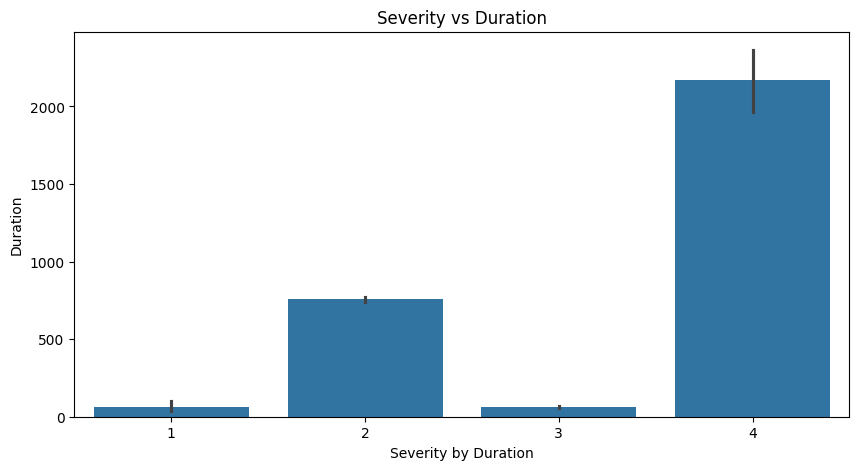

In [48]:
plt.figure(figsize=(10,5))
sbn.barplot(x=df['Severity'],y= df['Duration'])
plt.title('Severity vs Duration')
plt.ylabel('Duration')
plt.xlabel('Severity by Duration')
plt.show()

We can see here that the accidents with more duration are the accident with high level of severity, definitly Duration could be a good feature to predict the severity, now let's check the others features, but like we have to many I'll only check the strings and float64 and int64 features

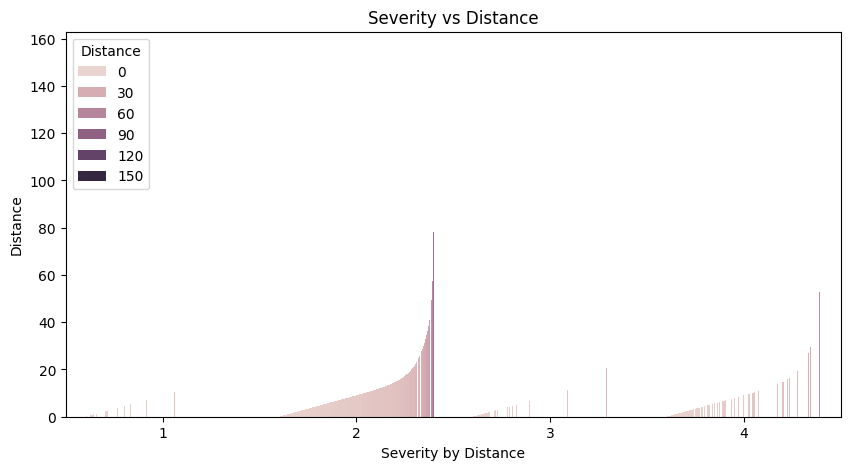

In [49]:
plt.figure(figsize=(10,5))
sbn.barplot(x=df['Severity'],y= df['Distance'],hue=df['Distance'])
plt.title('Severity vs Distance')
plt.ylabel('Distance')
plt.xlabel('Severity by Distance')
plt.show()

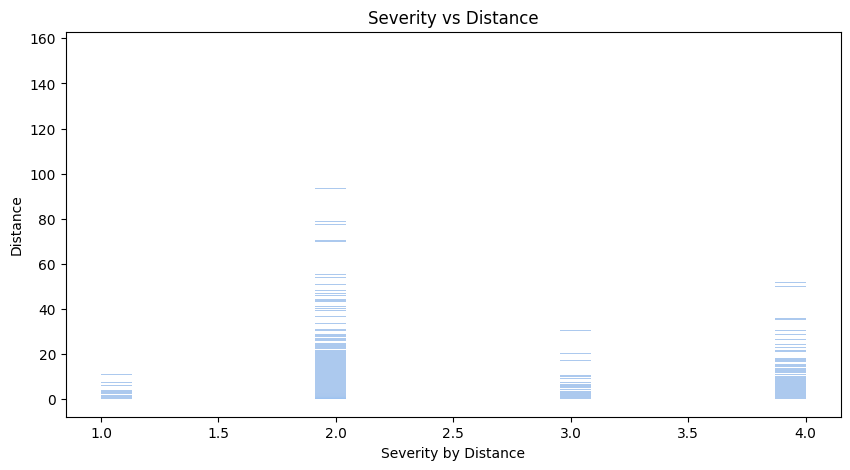

In [50]:
plt.figure(figsize=(10,5))
sbn.histplot(x=df['Severity'],y= df['Distance'])
plt.title('Severity vs Distance')
plt.ylabel('Distance')
plt.xlabel('Severity by Distance')
plt.show()

In [51]:
df.groupby('Severity')['Distance'].value_counts().sort_values()

Severity  Distance
2         23.74            1
          15.56            1
          15.58            1
          15.58            1
          15.57            1
                       ...  
          0.01         11893
          0.01         12508
1         0.00         22642
3         0.00         32065
2         0.00        261591
Name: count, Length: 30089, dtype: int64

In [52]:
(df.groupby('Severity')['Distance'].mean())

Severity
1   0.21
2   0.85
3   0.51
4   1.11
Name: Distance, dtype: float64

It's seem that we have more accidents with severity type2 and those are the accidents with more distance but thoso have a lot of accident with 0 distance too and maby for that the highest average of distance is for the accidents type 4 so there are a lot of outliers because the accidents to be an accident have to ve at least 0.1 mi of distance. Let's try now with Temperature feature.

<Axes: xlabel='Severity', ylabel='Temperature'>

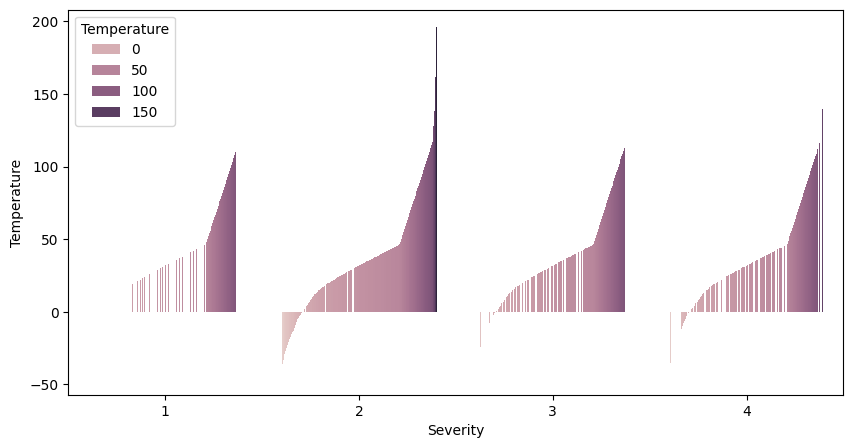

In [53]:
plt.figure(figsize=(10,5))
sbn.barplot(x=df['Severity'],y= df['Temperature'],hue=df['Temperature'])

Here we can see that should be a some outliers in temperature with values that reach even more than 150 F that no human could survive, and It's seems that most accident of lelv 2 on severity occurs in values of temp < 0, now I'll check Wind_chill

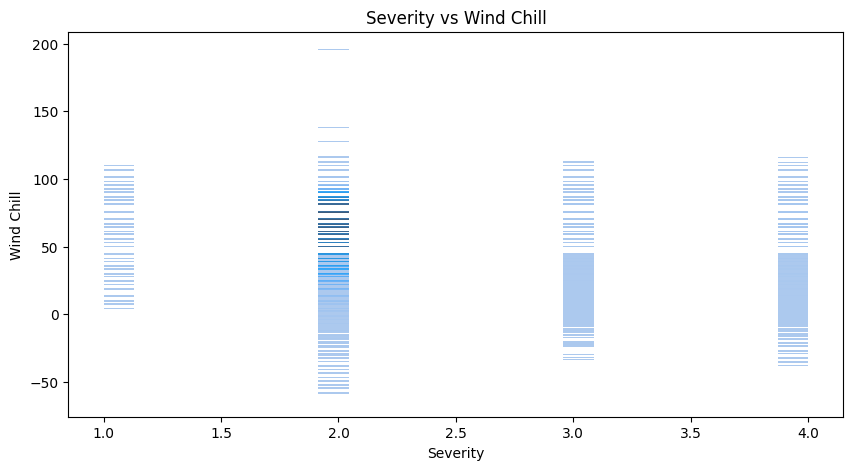

In [54]:
plt.figure(figsize=(10,5))
sbn.histplot(x=df['Severity'],y= df['Wind_Chill'])
plt.title('Severity vs Wind Chill')
plt.ylabel('Wind Chill')
plt.xlabel('Severity')
plt.show()

Everything seems ok here. Now let's check Humidity feature

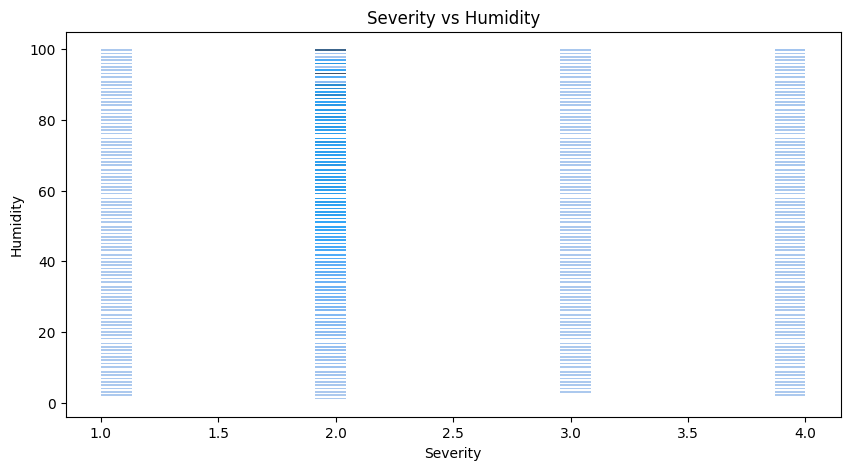

In [55]:
plt.figure(figsize=(10,5))
sbn.histplot(x=df['Severity'],y= df['Humidity'])
plt.title('Severity vs Humidity')
plt.ylabel('Humidity')
plt.xlabel('Severity')
plt.show()

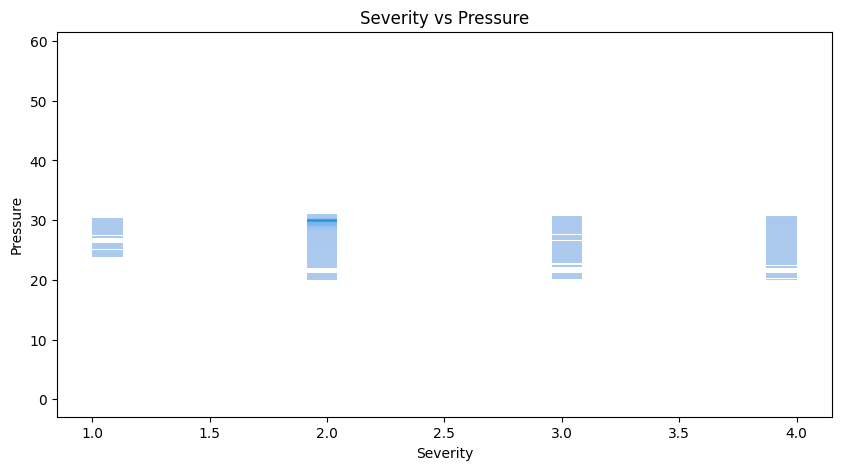

In [56]:
plt.figure(figsize=(10,5))
sbn.histplot(x=df['Severity'],y= df['Pressure'])
plt.title('Severity vs Pressure')
plt.ylabel('Pressure')
plt.xlabel('Severity')
plt.show()

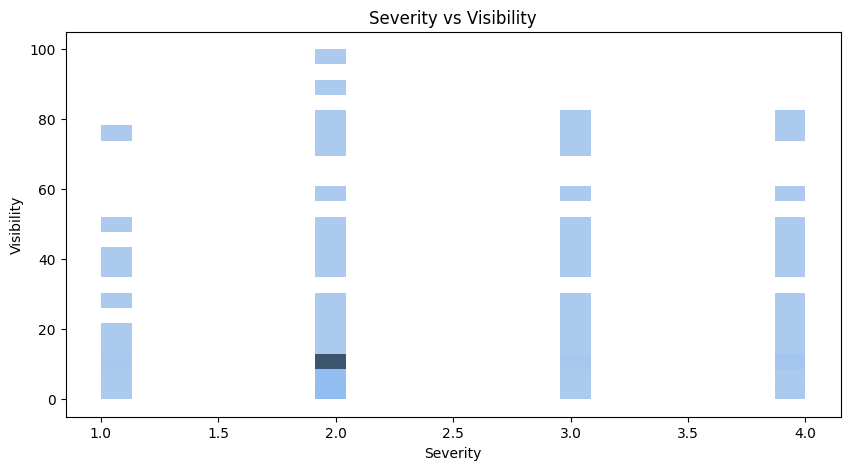

In [57]:
plt.figure(figsize=(10,5))
sbn.histplot(x=df['Severity'],y= df['Visibility'])
plt.title('Severity vs Visibility')
plt.ylabel('Visibility')
plt.xlabel('Severity')
plt.show()

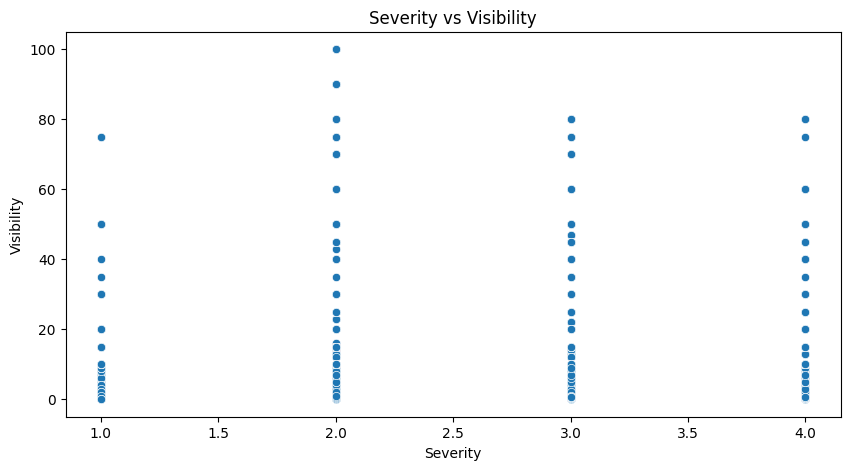

In [58]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=df['Severity'],y= df['Visibility'])
plt.title('Severity vs Visibility')
plt.ylabel('Visibility')
plt.xlabel('Severity')
plt.show()

In [59]:
df.groupby('Severity')['Visibility'].value_counts().sort_values()

Severity  Visibility
4         75.00               1
2         14.00               1
          35.00               1
          43.00               1
          16.00               1
                         ...   
          2.00            62750
          9.00            79556
          7.00            85605
4         10.00           89615
2         10.00         2710911
Name: count, Length: 158, dtype: int64

In [60]:
df.groupby('Severity')['Visibility'].mean().sort_values()

Severity
4   8.94
2   9.05
3   9.13
1   9.51
Name: Visibility, dtype: float64

There are a lot of accident in the level 2 and 4 with low visibility and the lower average of visibility is for the accidents lvl 4 and then the lvl 2.

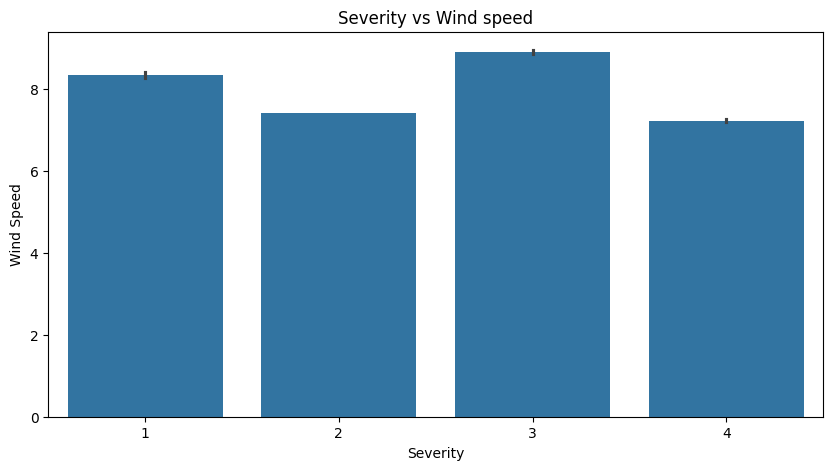

In [61]:
plt.figure(figsize=(10,5))
sbn.barplot(x=df['Severity'],y= df['Wind_Speed'])
plt.title('Severity vs Wind speed')
plt.ylabel('Wind Speed')
plt.xlabel('Severity')
plt.show()

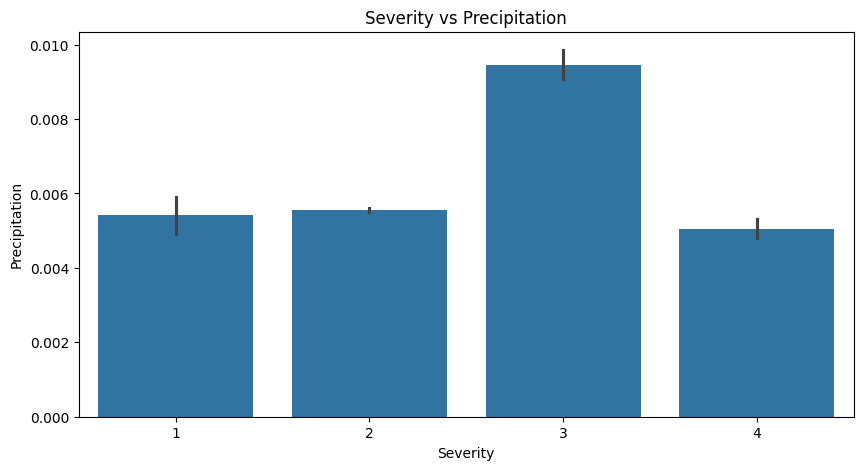

In [62]:
plt.figure(figsize=(10,5))
sbn.barplot(x=df['Severity'],y= df['Precipitation'])
plt.title('Severity vs Precipitation')
plt.ylabel('Precipitation')
plt.xlabel('Severity')
plt.show()

 Here I can see that there are a lot of accident Severity lvl 3. Now I'll proced to check for outliers.

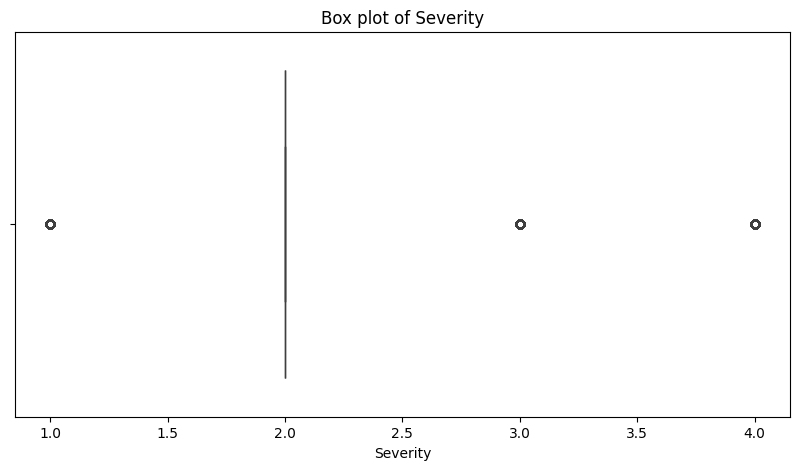

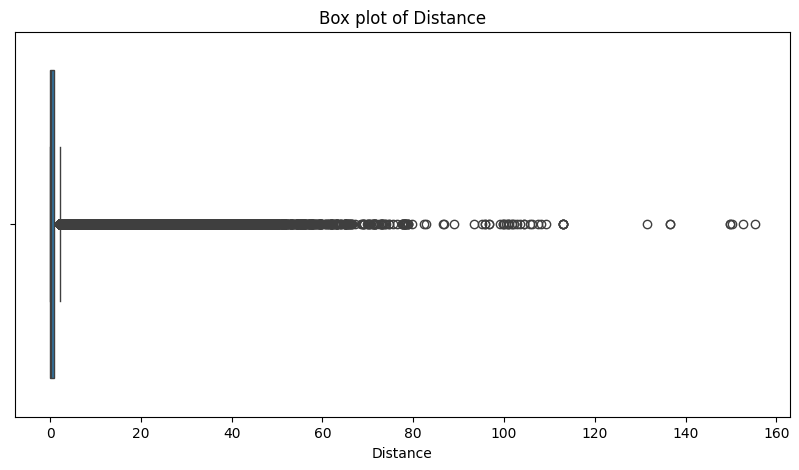

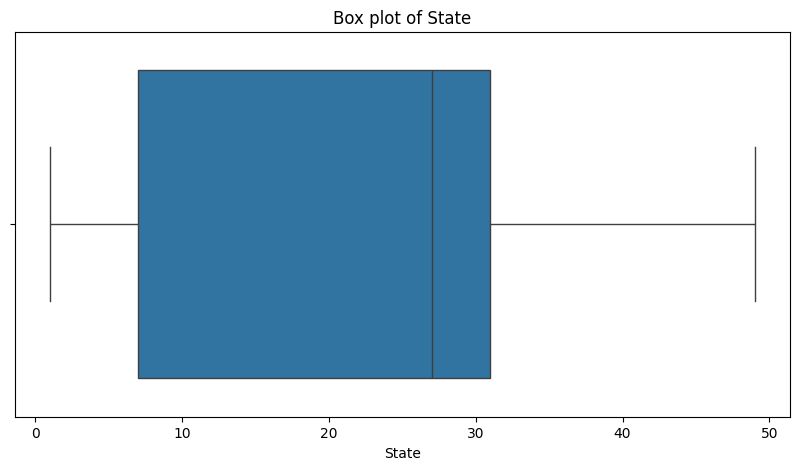

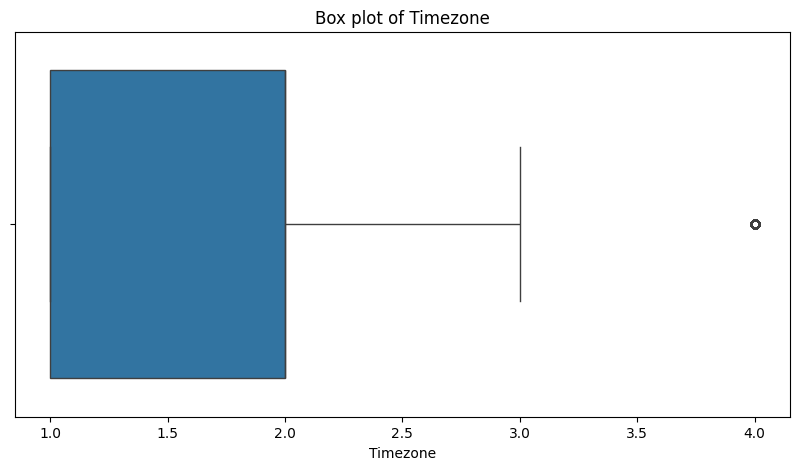

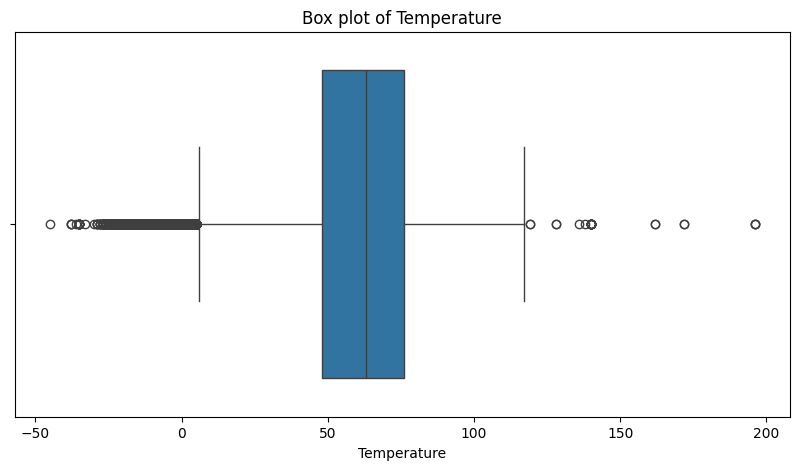

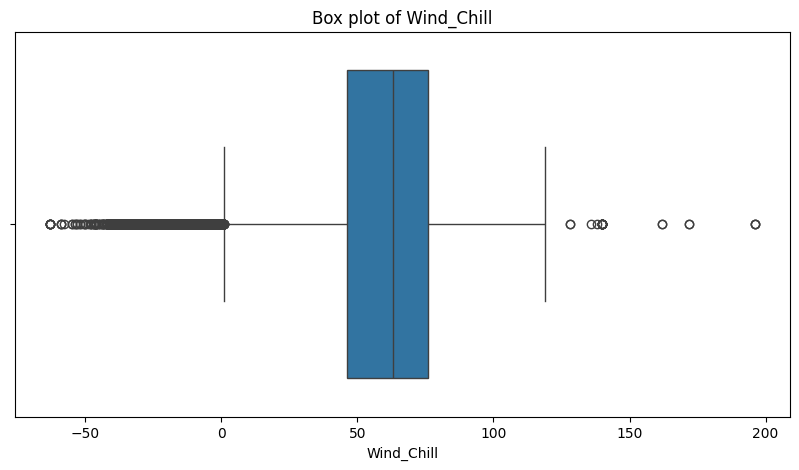

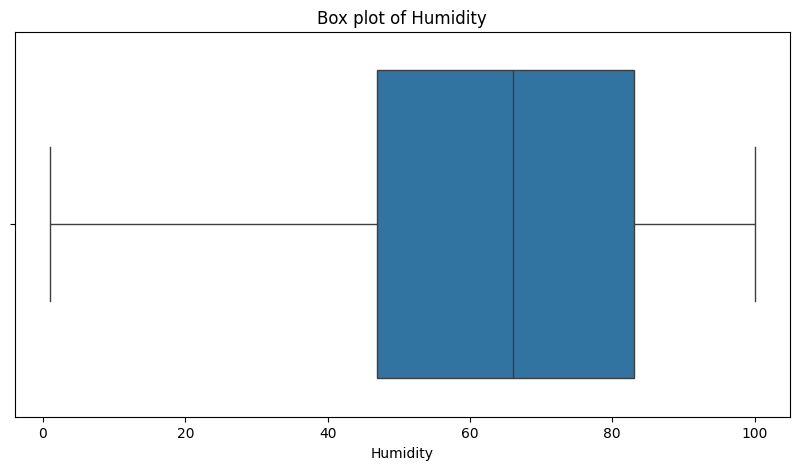

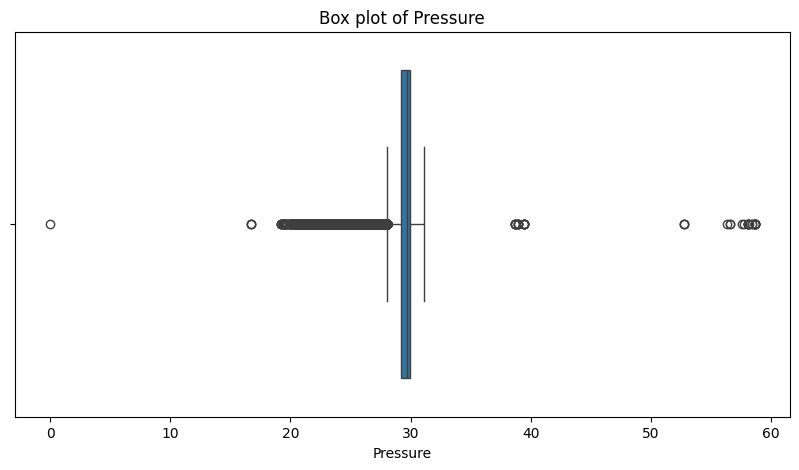

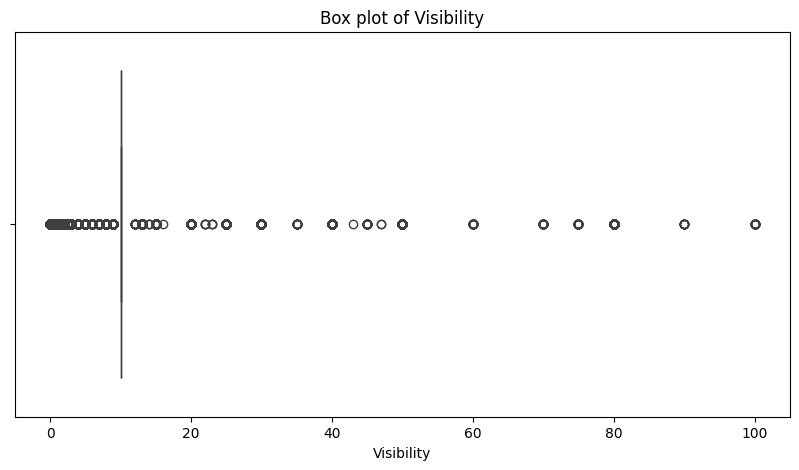

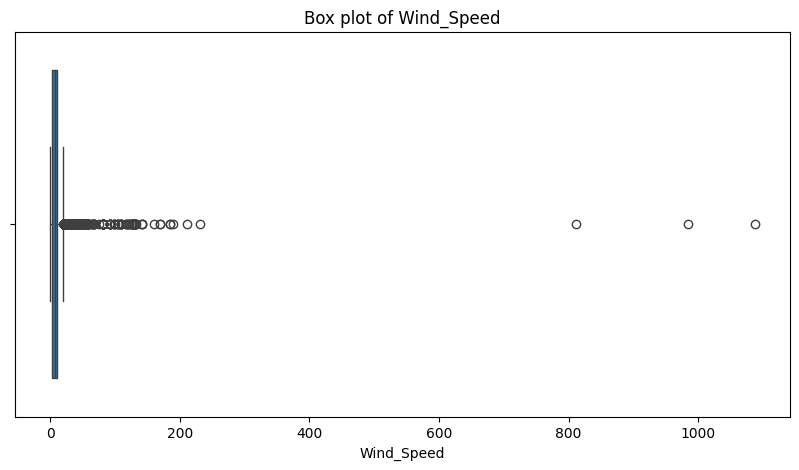

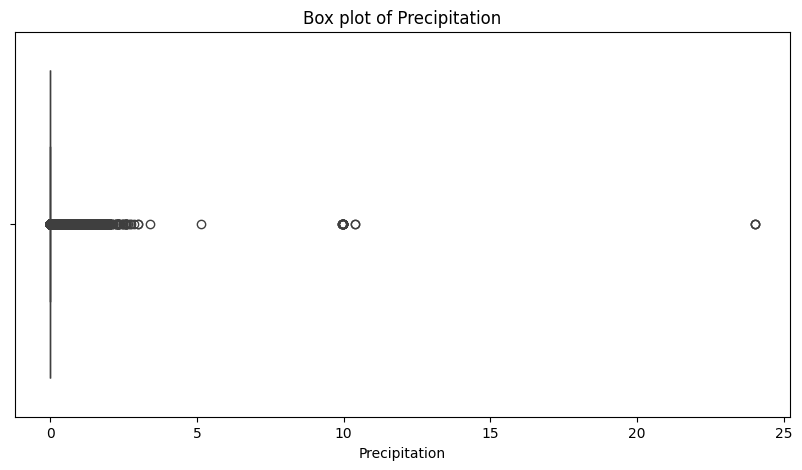

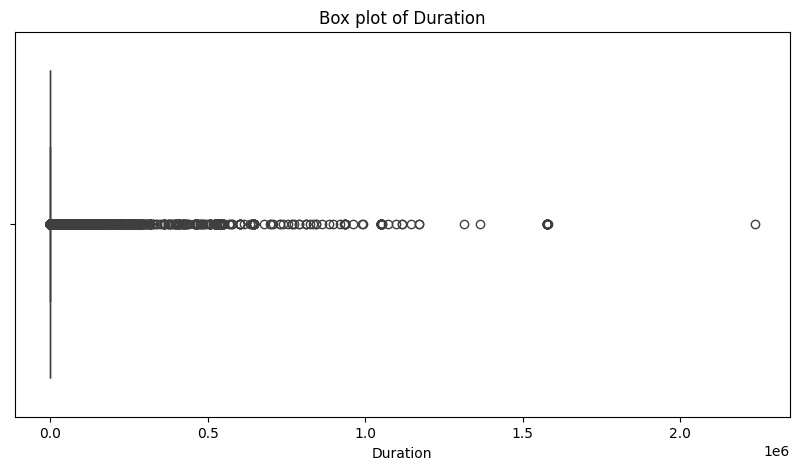

In [63]:
for i in df.columns:
    if df[i].dtype == 'int64' or df[i].dtype == 'float64':
        plt.figure(figsize=(10,5))
        sbn.boxplot(x= df[i])
        plt.title(f"Box plot of {i}")
        plt.xlabel(i)
        plt.show()

As we can see in the boxplots I have a lot of outliers like:
- Distance: I don't think that an accident has more than 1 or 2 milles even mega accident will be like 6 to 20 milles but no 60 miles.
- Duration: I don't think that an accident has more than 1 or 2 hours even the mefa accident could be like 8 hours that is in an extreme situation.
- Temperature and Wind_Child: The coldest state in USA is Alaska with 26 F averag and the hottest State is Florida araund 74 F average so I have values here of less than 26 and more than 74.
- Pressure: The average pressure is 29 to 30.
- Wind_Speed: The average wind speed of a Hurricane Category 1 is 74 - 95 mph and we can cleary see in the boxplot for Wind Speed that it have some values of more than that.

So, I have outliers in a few variables. I don't want to remove them. I gonna try to replacing those outliers with average values.

In [64]:
df['Distance'].describe()

count   3554549.00
mean          0.85
std           1.82
min           0.00
25%           0.07
50%           0.26
75%           0.92
max         155.19
Name: Distance, dtype: float64

Removing outliers from Distance, the 0 values with the mean, then the I'll set the lower and upper limit and I'll replace the upper values with the upper limit

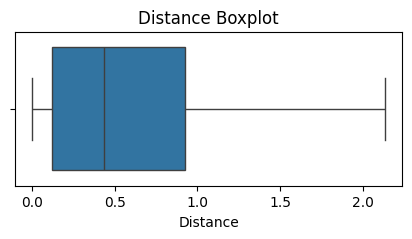

In [65]:
df.loc[df['Distance'] == 0,'Distance']= df['Distance'].mean()

q1= df['Distance'].quantile(0.25)
q3= df['Distance'].quantile(0.75)
iqr = q3 - q1 #Interquantile

#Now I'll set the upper limit
upper_limit= q3 + (1.5 * iqr)

df.loc[df['Distance'] > upper_limit,'Distance']= upper_limit

#Now we chechk for outliers again
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Distance'])
plt.title('Distance Boxplot')
plt.show()

There are no more outliers in Distance now is time for Duration.


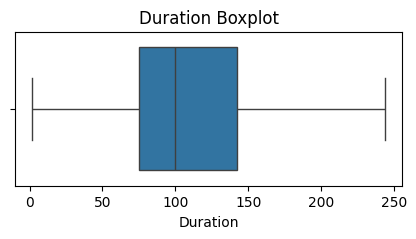

In [66]:
q1= df['Duration'].quantile(0.25)
q3= df['Duration'].quantile(0.75)
iqr = q3 - q1 #Interquantile

#Now I'll set the upper limit
upper_limit= q3 + (1.5 * iqr)
#lower_limit= q1 - (1.5 * iqr)

#Now replace all values grater than the upper limit 

df.loc[df['Duration'] > upper_limit, 'Duration'] = upper_limit

#Now we check again for outliers
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Duration'])
plt.title('Duration Boxplot')
plt.show()

#print(f"upper: {upper_limit} -- lower: {lower_limit}")

Distance fixed, now it's time for Temperature and then Wind Child.

count   3554549.00
mean         61.07
std          19.40
min         -45.00
25%          48.00
50%          63.00
75%          76.00
max         196.00
Name: Temperature, dtype: float64
upper: 118.0 -- lower: 6.0


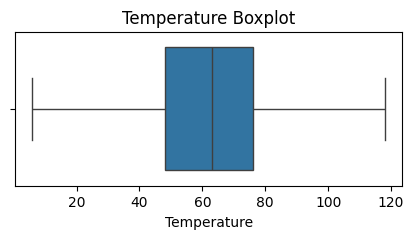

In [67]:
print(df['Temperature'].describe())
q1= df['Temperature'].quantile(0.25)
q3= df['Temperature'].quantile(0.75)
iqr = q3 - q1 #Interquantile

#Now I'll set the upper limit
upper_limit= q3 + (1.5 * iqr)
lower_limit= q1 - (1.5 * iqr)

print(f"upper: {upper_limit} -- lower: {lower_limit}")
#The coldest temperature in habitable zone in USA in 2024 was -18 F and the hottest was 129 
# and the lower and upper limits are pretty close to this so I'll replace all values that are
#above or below the limits and I'll replace with the limits
#Now replace all values grater than the upper limit 

df.loc[df['Temperature'] > upper_limit, 'Temperature'] = upper_limit
df.loc[df['Temperature'] < lower_limit, 'Temperature'] = lower_limit

#Now we check again for outliers
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Temperature'])
plt.title('Temperature Boxplot')
plt.show()


Now temperature is fixed with Wind_Chill should be similar

count   3554549.00
mean         59.74
std          21.69
min         -63.00
25%          46.00
50%          63.00
75%          76.00
max         196.00
Name: Wind_Chill, dtype: float64
upper: 121.0 -- lower: 1.0


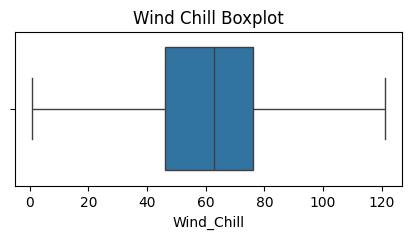

In [68]:
print(df['Wind_Chill'].describe())
q1= df['Wind_Chill'].quantile(0.25)
q3= df['Wind_Chill'].quantile(0.75)
iqr = q3 - q1 #Interquantile

#Now I'll set the upper limit
upper_limit= q3 + (1.5 * iqr)
lower_limit= q1 - (1.5 * iqr)

print(f"upper: {upper_limit} -- lower: {lower_limit}")

df.loc[df['Wind_Chill'] > upper_limit, 'Wind_Chill'] = upper_limit
df.loc[df['Wind_Chill'] < lower_limit, 'Wind_Chill'] = lower_limit

#Now we check again for outliers
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Wind_Chill'])
plt.title('Wind Chill Boxplot')
plt.show()

Now Wind Child is fixed too. Now it's time for Pressure variable.

count   3554549.00
mean         29.35
std           1.14
min           0.00
25%          29.19
50%          29.72
75%          29.97
max          58.63
Name: Pressure, dtype: float64
upper: 31 -- lower: 28


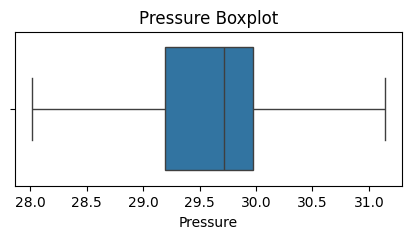

In [69]:
print(df['Pressure'].describe())
q1= df['Pressure'].quantile(0.25)
q3= df['Pressure'].quantile(0.75)
iqr = q3 - q1 #Interquantile
#Now I'll set the upper limit
upper_limit= q3 + (1.5 * iqr)
lower_limit= q1 - (1.5 * iqr)

print(f"upper: {round(upper_limit)} -- lower: {round(lower_limit)}")
#The normal range of air pressure at sea level is considered to be between 29.5 and 30.2 inches of mercury
#We will use this to filter out the data that is outside of this range and
#like the upper and lower limits are pretty close to those values 
# I'll replace the values outside of this range for the upper and lower limits

df.loc[df['Pressure'] > upper_limit, 'Pressure'] = upper_limit
df.loc[df['Pressure'] < lower_limit, 'Pressure'] = lower_limit

#Now we check again for outliers
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Pressure'])
plt.title('Pressure Boxplot')
plt.show()


Now the Pressure is fixed then I'll work with Wind_Speed. The problem here is the winds of more than 46 mph

count   3554549.00
mean          7.44
std           5.59
min           0.00
25%           3.00
50%           7.00
75%          10.00
max        1087.00
Name: Wind_Speed, dtype: float64


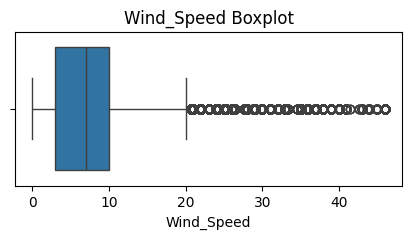

In [70]:
print(df['Wind_Speed'].describe())

#Now I'll filter the data to remove outliers with the winds of more than 46 mph and I'll replace by the limit that is 46 mph.

df.loc[df['Wind_Speed'] > 46, 'Wind_Speed'] = 46

#Now we check again for outliers
plt.figure(figsize=(5,2))
sbn.boxplot(x= df['Wind_Speed'])
plt.title('Wind_Speed Boxplot')
plt.show()

Now It's fixed with some some outliers in the box plot but those winds are probables so they're not outliers at all. Now that I already fix the outliers problems I will check the balance of the dataset again.

In [71]:
df['Severity'].value_counts()

Severity
2    3348445
4     112511
3      68026
1      25567
Name: count, dtype: int64

So as I noticed early there is a classic problem of imbalance because the severity #2 is the 94 % of the dataset, so we have to fix that, to fix it I'll  duplicate the minority class samples randomly or known as Random Oversampling


In [72]:
level1Severity= pd.concat([df[df['Severity'] == 1]]*10,ignore_index=True)
level3Severity= pd.concat([df[df['Severity'] == 3]]*9,ignore_index=True)
level4Severity= pd.concat([df[df['Severity'] == 4]]*9,ignore_index=True)

oversampled_df= pd.concat([df,level1Severity,level3Severity,level4Severity],ignore_index=True)

In [73]:
oversampled_df['Severity'].value_counts(normalize=True)

Severity
2   0.62
4   0.21
3   0.13
1   0.05
Name: proportion, dtype: float64

So here we fixed the problem of imbalance